In [89]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense
import pandas as pd
from tabulate import tabulate
import os
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.layers import Dropout, BatchNormalization
import matplotlib.pyplot as plt
from keras.callbacks import CSVLogger
import keras

CNN MODEL

In [102]:
def build_cnn_model(input_shape, num_classes, conv_params, dense_neurons, dropout_rate, use_batch_norm):
    model = Sequential()
    # Add the first convolutional layer
    model.add(Conv2D(conv_params[0], 
                     (3,3), 
                     padding='same',
                     input_shape=input_shape))
    if use_batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    for i in range(1,len(conv_params)):
        model.add(Conv2D(conv_params[i], 
                         (3,3),
                        padding='same'))
        if use_batch_norm:
            model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    model.add(Dropout(dropout_rate))
    model.add(Dense(dense_neurons, activation='relu'))
    model.add(Dropout(dropout_rate))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model


QUESTION 4:CNN MODEL FOR HYPERPARAMETER TUNING

TRAINING DATA

In [72]:
train_dir = 'inaturalist_12K/train'
test_dir = 'inaturalist_12K/val'
input_shape = (32, 32, 3)
num_classes = 10
batch_size = 32
epochs =10

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=input_shape[:2],
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=input_shape[:2], 
    batch_size=batch_size,
    class_mode='categorical',   
)

model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=epochs)

Found 9000 images belonging to 10 classes.
Found 999 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


Epoch 1/10
281/281 [==============================] - 57s 201ms/step - loss: 2.2679 - accuracy: 0.1317 - val_loss: 2.2117 - val_accuracy: 0.1683
Epoch 2/10
281/281 [==============================] - 56s 201ms/step - loss: 2.1978 - accuracy: 0.1852 - val_loss: 2.1529 - val_accuracy: 0.1996
Epoch 3/10
281/281 [==============================] - 56s 199ms/step - loss: 2.1051 - accuracy: 0.2281 - val_loss: 2.0965 - val_accuracy: 0.2379
Epoch 4/10
281/281 [==============================] - 56s 199ms/step - loss: 2.0341 - accuracy: 0.2662 - val_loss: 2.0480 - val_accuracy: 0.2692
Epoch 5/10
281/281 [==============================] - 56s 199ms/step - loss: 1.9911 - accuracy: 0.2794 - val_loss: 2.0292 - val_accuracy: 0.2560
Epoch 6/10
281/281 [==============================] - 56s 199ms/step - loss: 1.9463 - accuracy: 0.3042 - val_loss: 1.9845 - val_accuracy: 0.2903
Epoch 7/10
281/281 [==============================] - 979s 3s/step - loss: 1.9074 - accuracy: 0.3199 - val_loss: 1.9930 - val_accu

HYPERPARAMETER TUNING

In [3]:
def hyperparameter_tuning(train_dir, test_dir, input_shape, num_classes, filters, dense_neurons_list, dropout_rates, use_batch_norm_list, batch_size, epochs):
    results = []
    experiment_num = 0
    
    for conv_params in filters:
        for dense_neurons in dense_neurons_list:
            for dropout_rate in dropout_rates:
                for use_batch_norm in use_batch_norm_list:
                    experiment_num += 1
                    print(f"Experiment {experiment_num}: Conv Params: {conv_params}, Dense Neurons: {dense_neurons}, Dropout Rate: {dropout_rate}, Batch Normalization: {use_batch_norm}")
                    
                    # Build model
                    model = build_cnn_model(input_shape, num_classes, conv_params, dense_neurons, dropout_rate, use_batch_norm)
                    model.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
                    
                    # Callback for logging
                    log_dir = f"./logs/experiment_{experiment_num}"
                    os.makedirs(log_dir, exist_ok=True)
                    csv_logger = CSVLogger(os.path.join(log_dir, 'training_log.csv'))
                    
                    # Train model
                    history = model.fit(
                        train_generator,
                        steps_per_epoch=train_generator.samples // batch_size,
                        validation_data=validation_generator,
                        validation_steps=validation_generator.samples // batch_size,
                        epochs=epochs,
                        callbacks=[csv_logger]
                    )
                    
                    # Save results
                    result = {
                        'Experiment': experiment_num,
                        'filters': conv_params,
                        'Dense Neurons': dense_neurons,
                        'Dropout Rate': dropout_rate,
                        'Batch Normalization': use_batch_norm,
                        'Training Accuracy': history.history['accuracy'][-1],
                        'Validation Accuracy': history.history['val_accuracy'][-1],
                        'Training Loss': history.history['loss'][-1],
                        'Validation Loss': history.history['val_loss'][-1]
                    }
                    results.append(result)
    
    # Save results to CSV
    results_df = pd.DataFrame(results)
    results_df.to_csv('hyperparameter_tuning_results.csv', index=False)
    print("Hyperparameter tuning complete. Results saved to hyperparameter_tuning_results.csv")

# Define hyperparameters to sweep over
# conv_params_list = [
#     [{'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'}, {'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu'}],
#     [{'filters': 64, 'kernel_size': (3, 3), 'activation': 'relu'}, {'filters': 128, 'kernel_size': (3, 3), 'activation': 'relu'}],
#     [{'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'}, {'filters': 32, 'kernel_size': (3, 3), 'activation': 'relu'}]
# ]
filters =[[16,16,32,32,64],[32,32,64,64,64]]
use_batch_norm_list = [True, False]
dense_neurons_list = [128,256]
dropout_rates = [0.2, 0.3]


# Define other training parameters

num_classes = 10
batch_size = 32
epochs = 5

# Perform hyperparameter tuning
hyperparameter_tuning(train_dir, test_dir, input_shape, num_classes, filters, dense_neurons_list, dropout_rates, use_batch_norm_list, batch_size, epochs)


Experiment 1: Conv Params: [16, 16, 32, 32, 64], Dense Neurons: 128, Dropout Rate: 0.2, Batch Normalization: True
Epoch 1/5
281/281 [==============================] - 57s 202ms/step - loss: 2.2339 - accuracy: 0.1970 - val_loss: 2.3716 - val_accuracy: 0.1149
Epoch 2/5
281/281 [==============================] - 56s 200ms/step - loss: 2.0887 - accuracy: 0.2481 - val_loss: 2.1728 - val_accuracy: 0.2218
Epoch 3/5
281/281 [==============================] - 56s 199ms/step - loss: 2.0342 - accuracy: 0.2760 - val_loss: 2.1313 - val_accuracy: 0.2409
Epoch 4/5
281/281 [==============================] - 56s 200ms/step - loss: 1.9868 - accuracy: 0.2899 - val_loss: 2.0244 - val_accuracy: 0.2812
Epoch 5/5
281/281 [==============================] - 56s 201ms/step - loss: 1.9444 - accuracy: 0.3090 - val_loss: 1.9860 - val_accuracy: 0.3014


Experiment 2: Conv Params: [16, 16, 32, 32, 64], Dense Neurons: 128, Dropout Rate: 0.2, Batch Normalization: False
Epoch 1/5
281/281 [==============================] - 56s 198ms/step - loss: 2.2932 - accuracy: 0.1171 - val_loss: 2.2691 - val_accuracy: 0.1351
Epoch 2/5
281/281 [==============================] - 55s 197ms/step - loss: 2.2095 - accuracy: 0.1751 - val_loss: 2.1348 - val_accuracy: 0.2067
Epoch 3/5
281/281 [==============================] - 56s 200ms/step - loss: 2.1321 - accuracy: 0.2147 - val_loss: 2.0967 - val_accuracy: 0.2228
Epoch 4/5
281/281 [==============================] - 56s 199ms/step - loss: 2.0852 - accuracy: 0.2445 - val_loss: 2.0914 - val_accuracy: 0.2429
Epoch 5/5
281/281 [==============================] - 56s 198ms/step - loss: 2.0424 - accuracy: 0.2664 - val_loss: 2.0274 - val_accuracy: 0.2722


Experiment 3: Conv Params: [16, 16, 32, 32, 64], Dense Neurons: 128, Dropout Rate: 0.3, Batch Normalization: True
Epoch 1/5
281/281 [==============================] - 56s 197ms/step - loss: 2.2860 - accuracy: 0.1716 - val_loss: 2.3589 - val_accuracy: 0.1210
Epoch 2/5
281/281 [==============================] - 55s 196ms/step - loss: 2.1341 - accuracy: 0.2306 - val_loss: 2.1385 - val_accuracy: 0.2198
Epoch 3/5
281/281 [==============================] - 56s 201ms/step - loss: 2.0656 - accuracy: 0.2497 - val_loss: 2.0488 - val_accuracy: 0.2560
Epoch 4/5
281/281 [==============================] - 56s 199ms/step - loss: 2.0281 - accuracy: 0.2683 - val_loss: 2.2130 - val_accuracy: 0.2389
Epoch 5/5
281/281 [==============================] - 56s 201ms/step - loss: 1.9967 - accuracy: 0.2868 - val_loss: 2.0476 - val_accuracy: 0.2601


Experiment 4: Conv Params: [16, 16, 32, 32, 64], Dense Neurons: 128, Dropout Rate: 0.3, Batch Normalization: False
Epoch 1/5
281/281 [==============================] - 57s 200ms/step - loss: 2.2888 - accuracy: 0.1236 - val_loss: 2.2251 - val_accuracy: 0.1714
Epoch 2/5
281/281 [==============================] - 57s 202ms/step - loss: 2.1939 - accuracy: 0.1878 - val_loss: 2.1112 - val_accuracy: 0.2167
Epoch 3/5
281/281 [==============================] - 56s 199ms/step - loss: 2.1212 - accuracy: 0.2233 - val_loss: 2.1016 - val_accuracy: 0.2379
Epoch 4/5
281/281 [==============================] - 56s 199ms/step - loss: 2.0970 - accuracy: 0.2361 - val_loss: 2.0934 - val_accuracy: 0.2450
Epoch 5/5
281/281 [==============================] - 56s 199ms/step - loss: 2.0666 - accuracy: 0.2459 - val_loss: 2.0366 - val_accuracy: 0.2530


Experiment 5: Conv Params: [16, 16, 32, 32, 64], Dense Neurons: 256, Dropout Rate: 0.2, Batch Normalization: True
Epoch 1/5
281/281 [==============================] - 57s 202ms/step - loss: 2.2046 - accuracy: 0.1977 - val_loss: 2.5987 - val_accuracy: 0.1230
Epoch 2/5
281/281 [==============================] - 56s 200ms/step - loss: 2.0597 - accuracy: 0.2583 - val_loss: 2.0898 - val_accuracy: 0.2550
Epoch 3/5
281/281 [==============================] - 56s 200ms/step - loss: 2.0001 - accuracy: 0.2821 - val_loss: 1.9917 - val_accuracy: 0.2843
Epoch 4/5
281/281 [==============================] - 56s 201ms/step - loss: 1.9553 - accuracy: 0.3027 - val_loss: 2.1023 - val_accuracy: 0.2702
Epoch 5/5
281/281 [==============================] - 56s 201ms/step - loss: 1.9182 - accuracy: 0.3175 - val_loss: 1.9670 - val_accuracy: 0.2954


Experiment 6: Conv Params: [16, 16, 32, 32, 64], Dense Neurons: 256, Dropout Rate: 0.2, Batch Normalization: False
Epoch 1/5
281/281 [==============================] - 57s 201ms/step - loss: 2.2812 - accuracy: 0.1282 - val_loss: 2.2144 - val_accuracy: 0.1996
Epoch 2/5
281/281 [==============================] - 56s 199ms/step - loss: 2.1753 - accuracy: 0.1955 - val_loss: 2.1004 - val_accuracy: 0.2298
Epoch 3/5
281/281 [==============================] - 55s 197ms/step - loss: 2.1071 - accuracy: 0.2288 - val_loss: 2.1301 - val_accuracy: 0.2329
Epoch 4/5
281/281 [==============================] - 55s 195ms/step - loss: 2.0492 - accuracy: 0.2567 - val_loss: 2.0530 - val_accuracy: 0.2712
Epoch 5/5
281/281 [==============================] - 55s 196ms/step - loss: 2.0134 - accuracy: 0.2709 - val_loss: 2.0315 - val_accuracy: 0.2661


Experiment 7: Conv Params: [16, 16, 32, 32, 64], Dense Neurons: 256, Dropout Rate: 0.3, Batch Normalization: True
Epoch 1/5
281/281 [==============================] - 1340s 5s/step - loss: 2.2681 - accuracy: 0.1706 - val_loss: 2.3125 - val_accuracy: 0.1280
Epoch 2/5
281/281 [==============================] - 1693s 6s/step - loss: 2.1015 - accuracy: 0.2288 - val_loss: 2.0487 - val_accuracy: 0.2621
Epoch 3/5
281/281 [==============================] - 1200s 4s/step - loss: 2.0386 - accuracy: 0.2645 - val_loss: 2.0275 - val_accuracy: 0.2651
Epoch 4/5
281/281 [==============================] - 3768s 13s/step - loss: 1.9900 - accuracy: 0.2864 - val_loss: 1.9920 - val_accuracy: 0.2893
Epoch 5/5
281/281 [==============================] - 3261s 12s/step - loss: 1.9475 - accuracy: 0.2976 - val_loss: 1.9884 - val_accuracy: 0.2863


Experiment 8: Conv Params: [16, 16, 32, 32, 64], Dense Neurons: 256, Dropout Rate: 0.3, Batch Normalization: False
Epoch 1/5
281/281 [==============================] - 575s 2s/step - loss: 2.2826 - accuracy: 0.1217 - val_loss: 2.2452 - val_accuracy: 0.1522
Epoch 2/5
281/281 [==============================] - 55s 196ms/step - loss: 2.2130 - accuracy: 0.1784 - val_loss: 2.2032 - val_accuracy: 0.1835
Epoch 3/5
281/281 [==============================] - 55s 197ms/step - loss: 2.1420 - accuracy: 0.2139 - val_loss: 2.0997 - val_accuracy: 0.2188
Epoch 4/5
281/281 [==============================] - 55s 197ms/step - loss: 2.0869 - accuracy: 0.2390 - val_loss: 2.0675 - val_accuracy: 0.2379
Epoch 5/5
281/281 [==============================] - 57s 203ms/step - loss: 2.0578 - accuracy: 0.2463 - val_loss: 2.0399 - val_accuracy: 0.2692


Experiment 9: Conv Params: [32, 32, 64, 64, 64], Dense Neurons: 128, Dropout Rate: 0.2, Batch Normalization: True
Epoch 1/5
281/281 [==============================] - 57s 199ms/step - loss: 2.2219 - accuracy: 0.1938 - val_loss: 2.5504 - val_accuracy: 0.1190
Epoch 2/5
281/281 [==============================] - 56s 198ms/step - loss: 2.0728 - accuracy: 0.2584 - val_loss: 2.0991 - val_accuracy: 0.2389
Epoch 3/5
281/281 [==============================] - 55s 197ms/step - loss: 2.0080 - accuracy: 0.2850 - val_loss: 2.0073 - val_accuracy: 0.2863
Epoch 4/5
281/281 [==============================] - 1180s 4s/step - loss: 1.9784 - accuracy: 0.2966 - val_loss: 1.9563 - val_accuracy: 0.3024
Epoch 5/5
281/281 [==============================] - 1253s 4s/step - loss: 1.9069 - accuracy: 0.3245 - val_loss: 2.0188 - val_accuracy: 0.2893


Experiment 10: Conv Params: [32, 32, 64, 64, 64], Dense Neurons: 128, Dropout Rate: 0.2, Batch Normalization: False
Epoch 1/5
281/281 [==============================] - 55s 195ms/step - loss: 2.2707 - accuracy: 0.1305 - val_loss: 2.2022 - val_accuracy: 0.1643
Epoch 2/5
281/281 [==============================] - 55s 195ms/step - loss: 2.1799 - accuracy: 0.1913 - val_loss: 2.1687 - val_accuracy: 0.1976
Epoch 3/5
281/281 [==============================] - 55s 196ms/step - loss: 2.1415 - accuracy: 0.2065 - val_loss: 2.0975 - val_accuracy: 0.2470
Epoch 4/5
281/281 [==============================] - 55s 195ms/step - loss: 2.0881 - accuracy: 0.2370 - val_loss: 2.0627 - val_accuracy: 0.2470
Epoch 5/5
281/281 [==============================] - 55s 195ms/step - loss: 2.0413 - accuracy: 0.2607 - val_loss: 2.0501 - val_accuracy: 0.2591


Experiment 11: Conv Params: [32, 32, 64, 64, 64], Dense Neurons: 128, Dropout Rate: 0.3, Batch Normalization: True
Epoch 1/5
281/281 [==============================] - 1060s 4s/step - loss: 2.2590 - accuracy: 0.1818 - val_loss: 2.4441 - val_accuracy: 0.1250
Epoch 2/5
281/281 [==============================] - 4325s 15s/step - loss: 2.1133 - accuracy: 0.2390 - val_loss: 2.0906 - val_accuracy: 0.2349
Epoch 3/5
281/281 [==============================] - 54s 194ms/step - loss: 2.0509 - accuracy: 0.2620 - val_loss: 2.1299 - val_accuracy: 0.2298
Epoch 4/5
281/281 [==============================] - 55s 196ms/step - loss: 1.9921 - accuracy: 0.2859 - val_loss: 2.1345 - val_accuracy: 0.2409
Epoch 5/5
281/281 [==============================] - 55s 197ms/step - loss: 1.9645 - accuracy: 0.2998 - val_loss: 2.0127 - val_accuracy: 0.2833


Experiment 12: Conv Params: [32, 32, 64, 64, 64], Dense Neurons: 128, Dropout Rate: 0.3, Batch Normalization: False
Epoch 1/5
281/281 [==============================] - 56s 197ms/step - loss: 2.2673 - accuracy: 0.1376 - val_loss: 2.2106 - val_accuracy: 0.1774
Epoch 2/5
281/281 [==============================] - 55s 196ms/step - loss: 2.1969 - accuracy: 0.1855 - val_loss: 2.1621 - val_accuracy: 0.2036
Epoch 3/5
281/281 [==============================] - 56s 199ms/step - loss: 2.1634 - accuracy: 0.1955 - val_loss: 2.1520 - val_accuracy: 0.2036
Epoch 4/5
281/281 [==============================] - 55s 197ms/step - loss: 2.1295 - accuracy: 0.2174 - val_loss: 2.1198 - val_accuracy: 0.2157
Epoch 5/5
281/281 [==============================] - 56s 198ms/step - loss: 2.0962 - accuracy: 0.2339 - val_loss: 2.0651 - val_accuracy: 0.2661


Experiment 13: Conv Params: [32, 32, 64, 64, 64], Dense Neurons: 256, Dropout Rate: 0.2, Batch Normalization: True
Epoch 1/5
281/281 [==============================] - 56s 198ms/step - loss: 2.1838 - accuracy: 0.2114 - val_loss: 2.4869 - val_accuracy: 0.1310
Epoch 2/5
281/281 [==============================] - 56s 198ms/step - loss: 2.0483 - accuracy: 0.2642 - val_loss: 2.1060 - val_accuracy: 0.2278
Epoch 3/5
281/281 [==============================] - 56s 199ms/step - loss: 1.9886 - accuracy: 0.2958 - val_loss: 2.1872 - val_accuracy: 0.2429
Epoch 4/5
281/281 [==============================] - 55s 197ms/step - loss: 1.9365 - accuracy: 0.3151 - val_loss: 2.0597 - val_accuracy: 0.2581
Epoch 5/5
281/281 [==============================] - 55s 198ms/step - loss: 1.8828 - accuracy: 0.3267 - val_loss: 1.9841 - val_accuracy: 0.2843
Experiment 14: Conv Params: [32, 32, 64, 64, 64], Dense Neurons: 256, Dropout Rate: 0.2, Batch Normalization: False


Epoch 1/5
281/281 [==============================] - 56s 198ms/step - loss: 2.2971 - accuracy: 0.1138 - val_loss: 2.2456 - val_accuracy: 0.1623
Epoch 2/5
281/281 [==============================] - 328s 1s/step - loss: 2.2003 - accuracy: 0.1837 - val_loss: 2.1271 - val_accuracy: 0.2238
Epoch 3/5
281/281 [==============================] - 1586s 6s/step - loss: 2.1315 - accuracy: 0.2170 - val_loss: 2.0954 - val_accuracy: 0.2379
Epoch 4/5
281/281 [==============================] - 1407s 5s/step - loss: 2.0874 - accuracy: 0.2356 - val_loss: 2.0644 - val_accuracy: 0.2460
Epoch 5/5
281/281 [==============================] - 1451s 5s/step - loss: 2.0474 - accuracy: 0.2603 - val_loss: 2.0268 - val_accuracy: 0.2692


Experiment 15: Conv Params: [32, 32, 64, 64, 64], Dense Neurons: 256, Dropout Rate: 0.3, Batch Normalization: True
Epoch 1/5
281/281 [==============================] - 2633s 8s/step - loss: 2.2409 - accuracy: 0.1814 - val_loss: 2.4801 - val_accuracy: 0.1260
Epoch 2/5
281/281 [==============================] - 55s 194ms/step - loss: 2.0800 - accuracy: 0.2498 - val_loss: 2.0359 - val_accuracy: 0.2873
Epoch 3/5
281/281 [==============================] - 55s 195ms/step - loss: 2.0181 - accuracy: 0.2696 - val_loss: 2.1615 - val_accuracy: 0.1905
Epoch 4/5
281/281 [==============================] - 55s 195ms/step - loss: 1.9675 - accuracy: 0.3016 - val_loss: 2.1510 - val_accuracy: 0.2681
Epoch 5/5
281/281 [==============================] - 1882s 7s/step - loss: 1.9247 - accuracy: 0.3175 - val_loss: 2.4189 - val_accuracy: 0.1542


Experiment 16: Conv Params: [32, 32, 64, 64, 64], Dense Neurons: 256, Dropout Rate: 0.3, Batch Normalization: False
Epoch 1/5
281/281 [==============================] - 393s 1s/step - loss: 2.2934 - accuracy: 0.1124 - val_loss: 2.2796 - val_accuracy: 0.1492
Epoch 2/5
281/281 [==============================] - 54s 194ms/step - loss: 2.2178 - accuracy: 0.1718 - val_loss: 2.1655 - val_accuracy: 0.2006
Epoch 3/5
281/281 [==============================] - 54s 194ms/step - loss: 2.1509 - accuracy: 0.2086 - val_loss: 2.1094 - val_accuracy: 0.2147
Epoch 4/5
281/281 [==============================] - 265s 945ms/step - loss: 2.1092 - accuracy: 0.2244 - val_loss: 2.0776 - val_accuracy: 0.2500
Epoch 5/5
281/281 [==============================] - 809s 3s/step - loss: 2.0775 - accuracy: 0.2390 - val_loss: 2.0518 - val_accuracy: 0.2490
Hyperparameter tuning complete. Results saved to hyperparameter_tuning_results.csv


In [65]:
!pip install tabulate

All hyperparameters and their values

In [84]:
results_df = pd.read_csv('hyperparameter_tuning_results.csv')

experiment_metrics = []

for index, row in results_df.iterrows():
    experiment_metrics.append([
        row['Experiment'],
        row['filters'],
        row['Dense Neurons'],
        row['Dropout Rate'],
        row['Batch Normalization'],
        row['Training Accuracy'],
        row['Validation Accuracy'],
        row['Training Loss'],
        row['Validation Loss']
    ])
headers = ['Experiment', 'Filters', 'Dense Neurons', 'Dropout Rate', 'Batch Normalization', 
           'Validation Accuracy']

print(tabulate(experiment_metrics, headers=headers, tablefmt='plain', numalign='center'))


                                Experiment   Filters     Dense Neurons    Dropout Rate    Batch Normalization    Validation Accuracy
1   [16, 16, 32, 32, 64]  128      0.2       True          0.308987         0.301411            1.94437                1.98598
2   [16, 16, 32, 32, 64]  128      0.2       False         0.266392         0.272177            2.04236                2.02742
3   [16, 16, 32, 32, 64]  128      0.3       True          0.286797         0.260081            1.99668                2.04756
4   [16, 16, 32, 32, 64]  128      0.3       False         0.245874         0.253024            2.06661                2.03659
5   [16, 16, 32, 32, 64]  256      0.2       True          0.317462         0.295363            1.91817                 1.967
6   [16, 16, 32, 32, 64]  256      0.2       False         0.270852         0.266129            2.01335                2.03147
7   [16, 16, 32, 32, 64]  256      0.3       True          0.297614         0.28629             1.94754   

GRAPHS

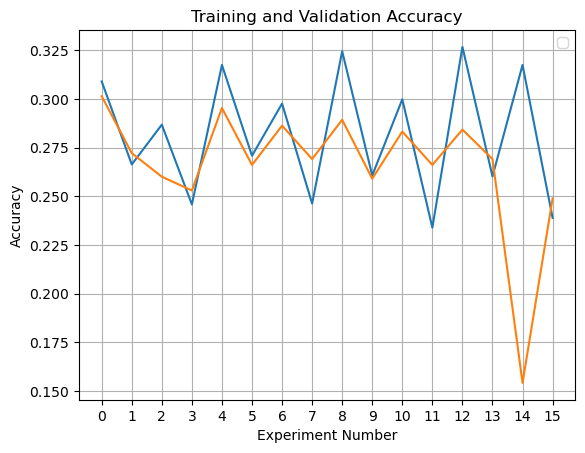

In [68]:
train_acc_vals = results_df['Training Accuracy'].to_list()
val_acc_vals = results_df['Validation Accuracy'].to_list()
x=[i for i in range(len(train_acc_vals))]

plt.plot(x,train_acc_vals)
plt.plot(x,val_acc_vals)

plt.title('Training and Validation Accuracy')
plt.xlabel('Experiment Number')
plt.ylabel('Accuracy')
plt.xticks(x)
plt.legend()
plt.grid(True)

plt.show()


Graphs for all experiments

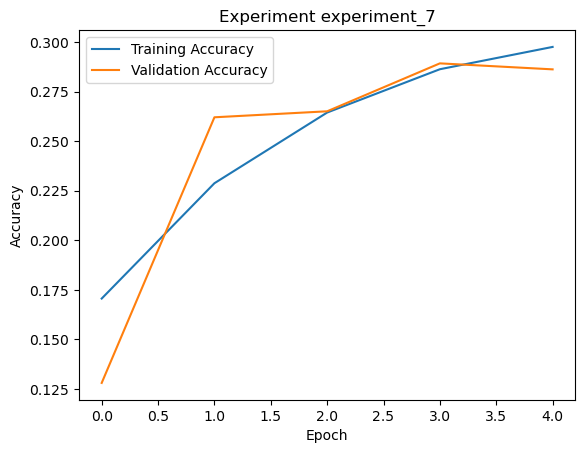

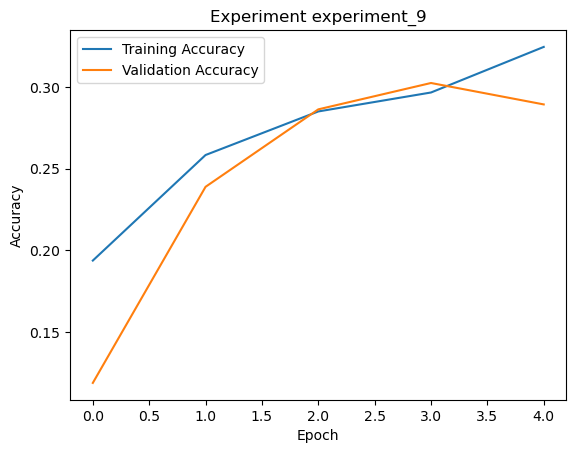

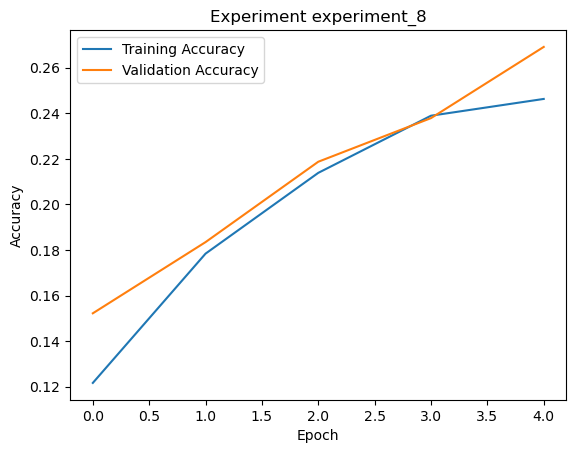

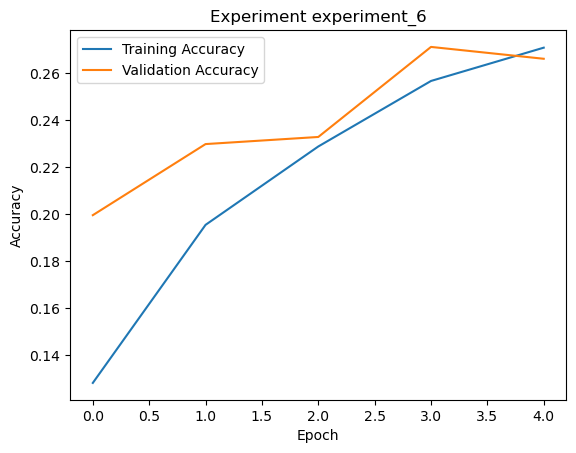

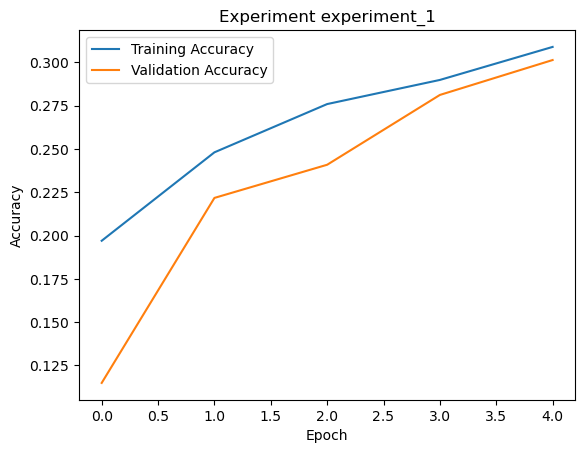

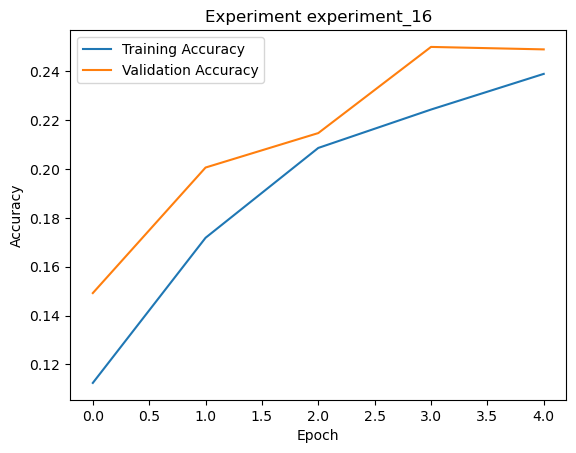

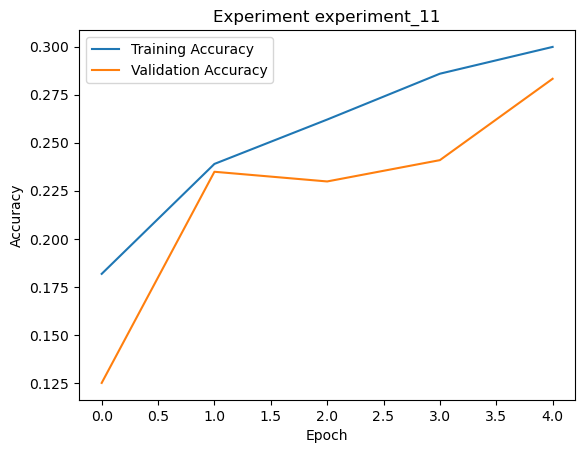

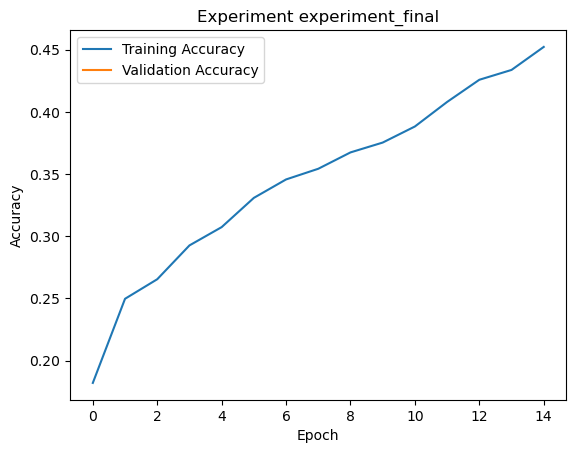

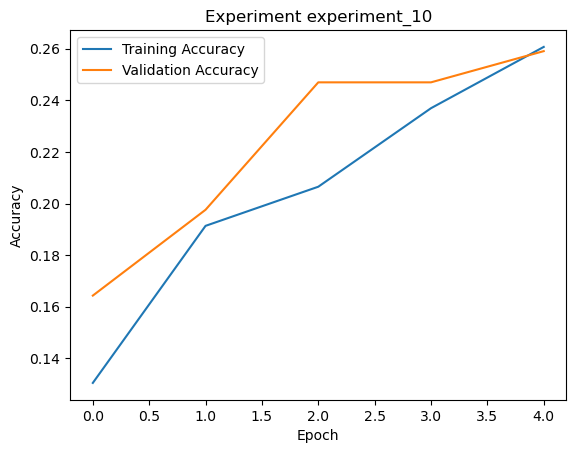

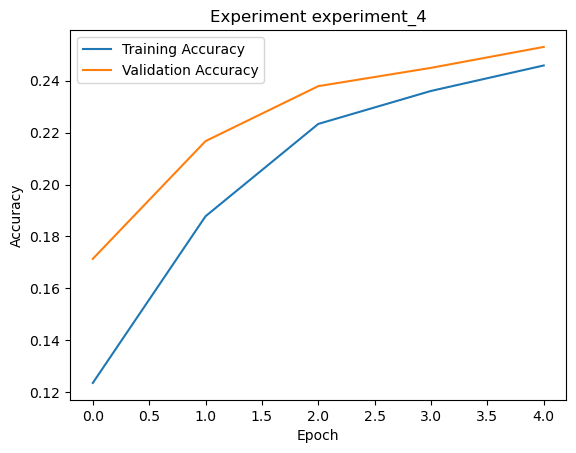

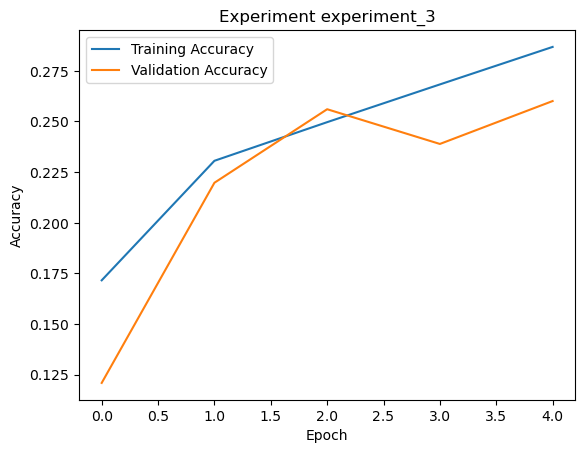

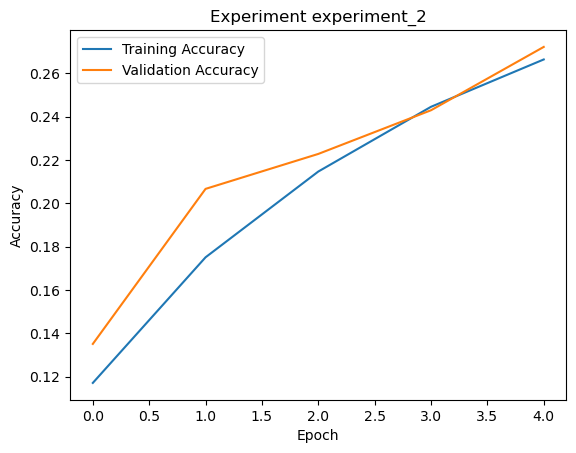

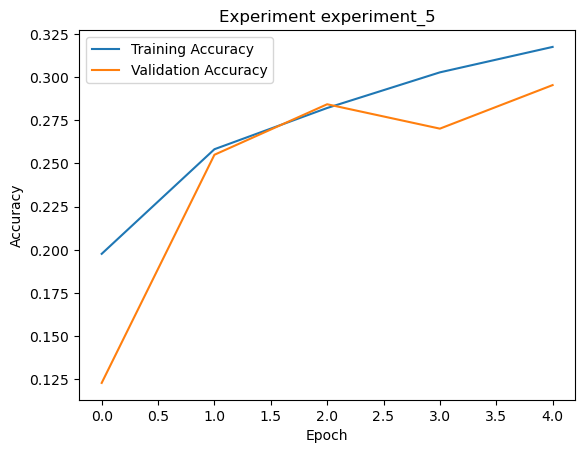

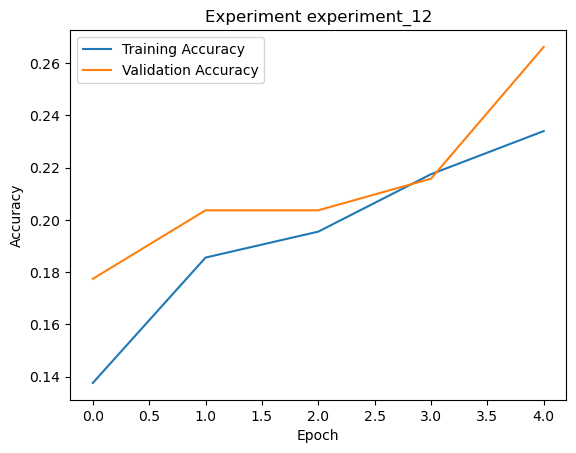

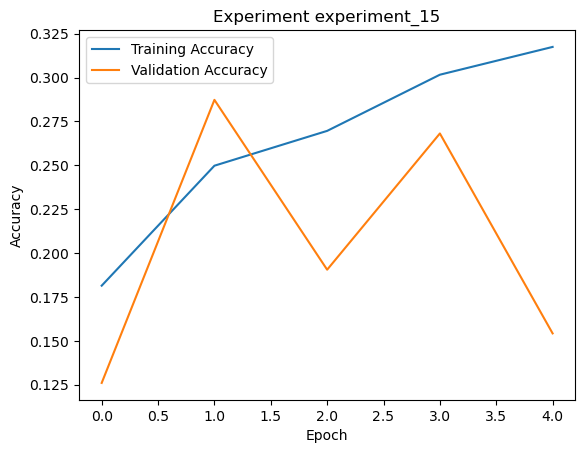

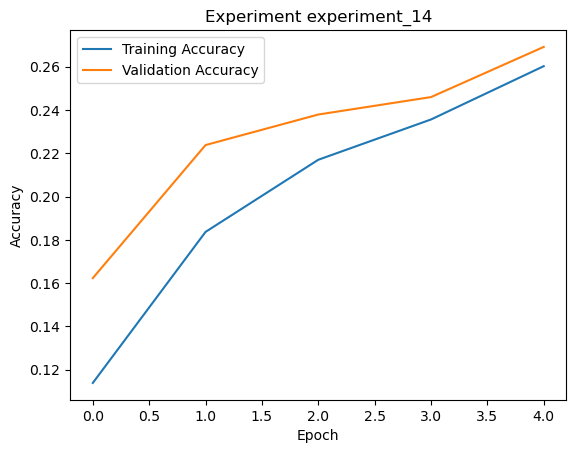

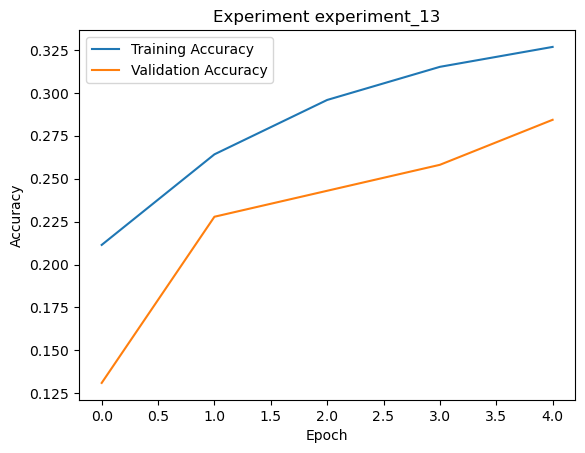

In [69]:
def plot_all_experiments():
    log_dir = 'logs'
    experiment_folders = [d for d in os.listdir(log_dir) if os.path.isdir(os.path.join(log_dir, d))]
    for experiment_folder in experiment_folders:
        # Create a new figure for each experiment
        plt.figure()
        training_log = pd.read_csv(os.path.join(log_dir, experiment_folder, 'training_log.csv'))
        plt.plot(training_log['accuracy'], label='Training Accuracy')
        plt.plot(training_log['val_accuracy'], label='Validation Accuracy')
        plt.title(f'Experiment {experiment_folder}')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show() 

plot_all_experiments()

Best hyper parameter configuration

In [78]:
results_df = pd.read_csv('hyperparameter_tuning_results.csv')
top_result = results_df.sort_values(by='Validation Accuracy', ascending=False).head(1)
print(top_result)

   Experiment               filters  Dense Neurons  Dropout Rate  \
0           1  [16, 16, 32, 32, 64]            128           0.2   

   Batch Normalization  Training Accuracy  Validation Accuracy  Training Loss  \
0                 True           0.308987             0.301411       1.944366   

   Validation Loss  
0         1.985982  


QUESTION 5: Testing

Best model on Test data

In [77]:
best_config = results_df.iloc[0]  
best_filters = eval(best_config['filters']) 
best_units = best_config['Dense Neurons']
best_rate = best_config['Dropout Rate']
best_norm = best_config['Batch Normalization']

best_model = build_cnn_model(input_shape, num_classes, best_filters, best_units, best_rate, best_norm)
best_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

log_dir = f"./logs/experiment_final"
os.makedirs(log_dir, exist_ok=True)
csv_logger = CSVLogger(os.path.join(log_dir, 'training_log.csv'))

history = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=15,  # Train for a few epochs on the combined data,
    callbacks =[csv_logger]
)

test_loss, test_accuracy = best_model.evaluate(test_generator)
print("Test Accuracy:", test_accuracy)

Epoch 1/15
281/281 [==============================] - 51s 180ms/step - loss: 2.2244 - accuracy: 0.1930
Epoch 2/15
281/281 [==============================] - 51s 181ms/step - loss: 2.1009 - accuracy: 0.2347
Epoch 3/15
281/281 [==============================] - 51s 180ms/step - loss: 2.0282 - accuracy: 0.2752
Epoch 4/15
281/281 [==============================] - 51s 182ms/step - loss: 1.9820 - accuracy: 0.2920
Epoch 5/15
281/281 [==============================] - 51s 182ms/step - loss: 1.9385 - accuracy: 0.3098
Epoch 6/15
281/281 [==============================] - 51s 183ms/step - loss: 1.9022 - accuracy: 0.3185
Epoch 7/15
281/281 [==============================] - 51s 181ms/step - loss: 1.8638 - accuracy: 0.3432
Epoch 8/15
281/281 [==============================] - 52s 183ms/step - loss: 1.8361 - accuracy: 0.3438
Epoch 9/15
281/281 [==============================] - 51s 181ms/step - loss: 1.7927 - accuracy: 0.3666
Epoch 10/15
281/281 [==============================] - 51s 182ms/step - l

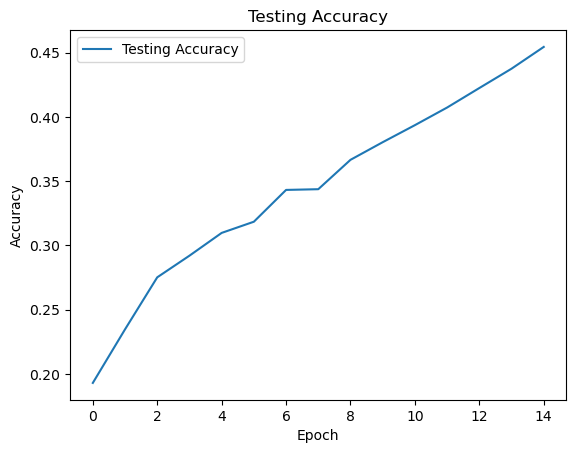

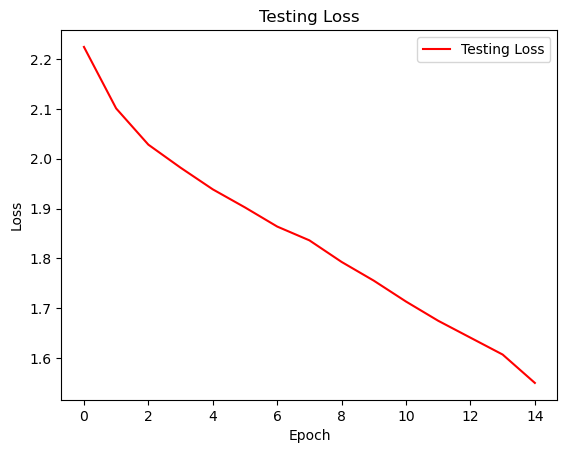

In [85]:
testing_log = pd.read_csv(os.path.join(log_dir, 'training_log.csv'))

# Plot the testing accuracy
plt.plot(testing_log['accuracy'], label='Testing Accuracy')
plt.title('Testing Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the testing loss
plt.plot(testing_log['loss'], label='Testing Loss', color='red')
plt.title('Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


(b) Provide a 10 x 3 grid containing sample images from the test data and predictions made by your best model (more marks for presenting this grid creatively).

63/63 [==============================] - 11s 171ms/step


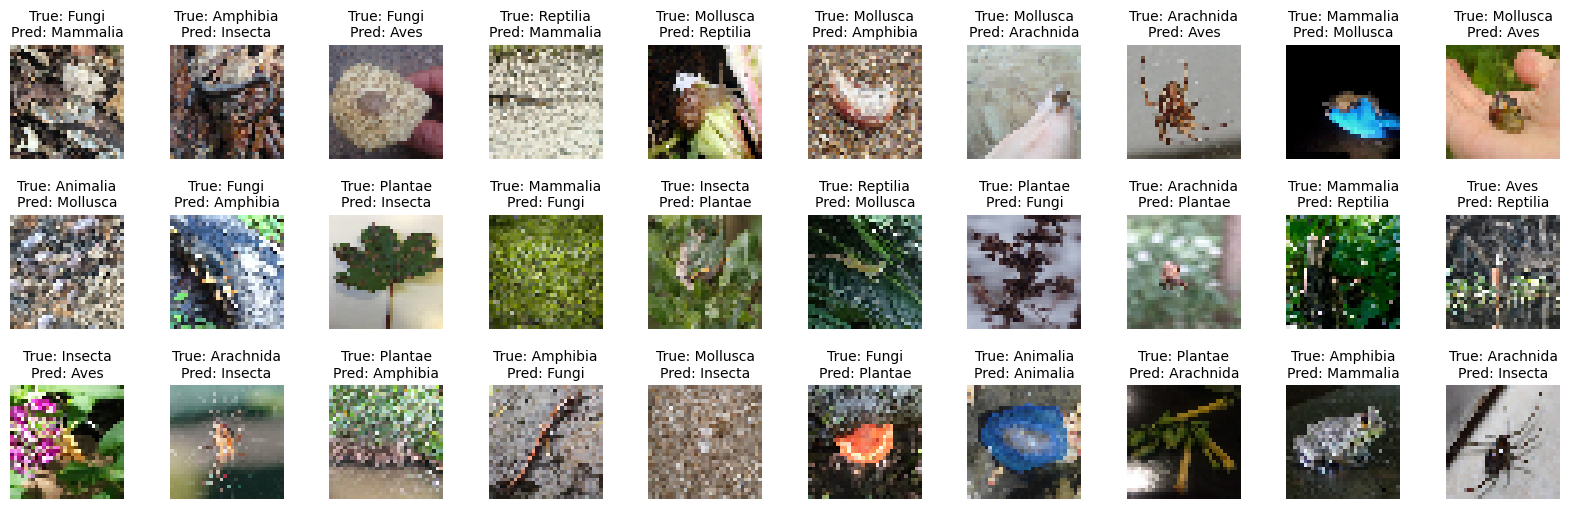

In [103]:
def plot_sample_images_with_predictions(model, test_generator, num_images=10):
    predictions = model.predict(test_generator)

    sample_images, sample_labels = next(test_generator)

    class_labels = list(test_generator.class_indices.keys())

    fig, axes = plt.subplots(3, 10, figsize=(20, 6))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
    for i, ax_row in enumerate(axes):
        for j, ax in enumerate(ax_row):
            index = i * 10 + j
            ax.imshow(sample_images[index])
            ax.axis('off')
            true_label = class_labels[np.argmax(sample_labels[index])]
            pred_label = class_labels[np.argmax(predictions[index])]
            ax.set_title(f'True: {true_label}\nPred: {pred_label}', fontsize=10)
    plt.show()

plot_sample_images_with_predictions(best_model, test_generator)


(c) Visualise all the filters in the first layer of your best model for a random image from the test set. If there are 64 filters in the first layer plot them in an 8 x 8 grid.

In [90]:
from keras.callbacks import ModelCheckpoint

# Define the filename for saving the best model
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)

# Train the model with the callback
history = model.fit(train_generator,
                    steps_per_epoch=train_generator.samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=validation_generator.samples // batch_size,
                    epochs=epochs,
                    callbacks=[model_checkpoint])


Epoch 1/10
281/281 [==============================] - ETA: 0s - loss: 0.8687 - accuracy: 0.6882
Epoch 1: val_accuracy improved from -inf to 0.30746, saving model to best_model.h5
281/281 [==============================] - 56s 199ms/step - loss: 0.8687 - accuracy: 0.6882 - val_loss: 2.8533 - val_accuracy: 0.3075
Epoch 2/10
281/281 [==============================] - ETA: 0s - loss: 0.7835 - accuracy: 0.7220
Epoch 2: val_accuracy did not improve from 0.30746
281/281 [==============================] - 56s 199ms/step - loss: 0.7835 - accuracy: 0.7220 - val_loss: 2.8692 - val_accuracy: 0.3065
Epoch 3/10
281/281 [==============================] - ETA: 0s - loss: 0.6906 - accuracy: 0.7526
Epoch 3: val_accuracy did not improve from 0.30746
281/281 [==============================] - 56s 200ms/step - loss: 0.6906 - accuracy: 0.7526 - val_loss: 3.3085 - val_accuracy: 0.2903
Epoch 4/10
281/281 [==============================] - ETA: 0s - loss: 0.6191 - accuracy: 0.7826
Epoch 4: val_accuracy did not

1/1 [==============================] - 0s 13ms/step


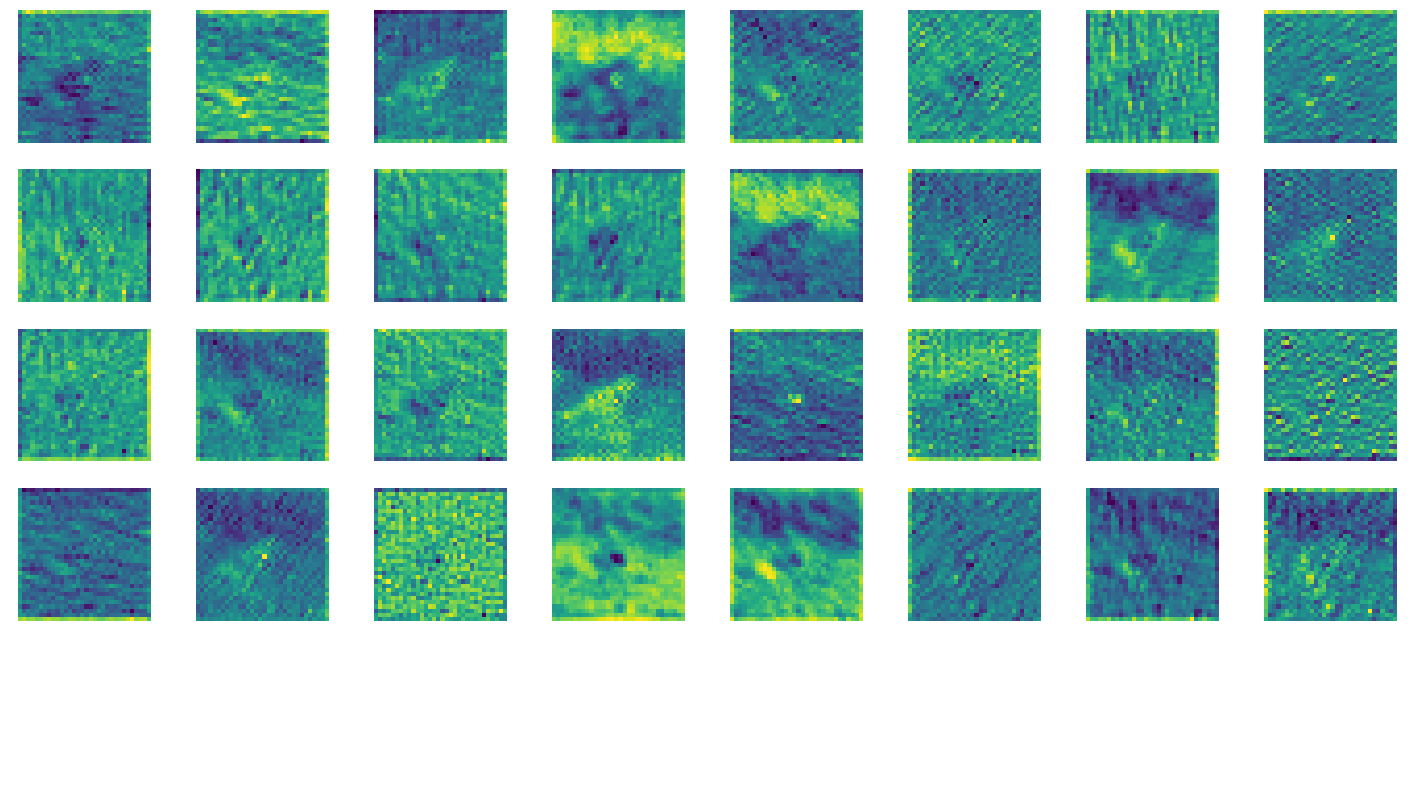

In [104]:
from tensorflow.keras.models import load_model

best_model = load_model('best_model.h5')

first_conv_layer = best_model.layers[0]
activation_model = Model(inputs=best_model.input, outputs=first_conv_layer.output)
image_height, image_width = 32, 32

random_index = np.random.choice(len(test_generator))
random_image_batch = test_generator[random_index][0]  
random_image = random_image_batch[0]

preprocessed_image = random_image / 255.0  # Assuming rescaling by 255
assert preprocessed_image.shape == (image_height, image_width, 3), f"Image shape was: {preprocessed_image.shape}"
preprocessed_image_batch = np.expand_dims(preprocessed_image, axis=0)

activations = activation_model.predict(preprocessed_image_batch)
num_filters = activations.shape[-1]

num_rows = num_filters // 8 + 1
fig, axes = plt.subplots(num_rows, 8, figsize=(18, 10))
for i, ax in enumerate(axes.flat):
    if i < num_filters:
        ax.imshow(activations[0, :, :, i], cmap='viridis')
        ax.axis('off')
    else:
        ax.axis('off')  # Hide unused subplots

plt.show()


END